In [4]:
import numpy as np
from scipy.integrate import simps
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt,pow,log
import matplotlib.cm as cm
from scipy.integrate import quad
import h5py

In [12]:
!wget http://supernova.lbl.gov/Union/figures/SCPUnion2.1_mu_vs_z.txt
d = np.genfromtxt('SCPUnion2.1_mu_vs_z.txt')
z1 = d.T[1]
mu1 = d.T[2]
errmu= d.T[3]
dlabel = 'SCP_2.1'
label = {"Z_SN":z1,"DMdata_SN":mu1,"Error_DM_SN":errmu}
data_SN=pd.DataFrame(label)
#print(data_SN)
sort_data_SN=data_SN.sort_values(by=['Z_SN'],ignore_index=True)
!wget https://supernova.lbl.gov/Union/figures/SCPUnion2.1_covmat_sys.txt
cov_mat = np.genfromtxt('SCPUnion2.1_covmat_sys.txt')
z=sort_data_SN.Z_SN
mu=sort_data_SN.DMdata_SN

URL transformed to HTTPS due to an HSTS policy
--2022-02-02 09:33:16--  https://supernova.lbl.gov/Union/figures/SCPUnion2.1_mu_vs_z.txt
Resolving supernova.lbl.gov (supernova.lbl.gov)... 128.3.28.88
Connecting to supernova.lbl.gov (supernova.lbl.gov)|128.3.28.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33899 (33K) [text/plain]
Saving to: ‘SCPUnion2.1_mu_vs_z.txt.49’

SCPUnion2.1_mu_vs_z 100%[===================>]  33.10K   100KB/s    in 0.3s    

2022-02-02 09:33:18 (100 KB/s) - ‘SCPUnion2.1_mu_vs_z.txt.49’ saved [33899/33899]

--2022-02-02 09:33:18--  https://supernova.lbl.gov/Union/figures/SCPUnion2.1_covmat_sys.txt
Resolving supernova.lbl.gov (supernova.lbl.gov)... 128.3.28.88
Connecting to supernova.lbl.gov (supernova.lbl.gov)|128.3.28.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6037238 (5.8M) [text/plain]
Saving to: ‘SCPUnion2.1_covmat_sys.txt.19’

SCPUnion2.1_covmat_ 100%[===================>]   5.76M  1.45MB/s    

In [13]:
print(sort_data_SN)
print(z[1])
print(mu[1])


         Z_SN  DMdata_SN  Error_DM_SN
0    0.015000  34.163504     0.161453
1    0.015000  34.111411     0.213389
2    0.015000  34.379773     0.217349
3    0.015027  33.950192     0.178117
4    0.015100  34.525875     0.213682
..        ...        ...          ...
575  1.340000  45.067506     0.275015
576  1.350000  44.827065     0.185705
577  1.370000  45.049713     0.262748
578  1.390000  44.876234     0.250632
579  1.414000  44.803766     0.346181

[580 rows x 3 columns]
0.015
34.1114109643


MCMC for Omega_m, n,H0 for SN events

In [14]:
#omega_m, n , H0 SN
#number of samples 
sampl= 10000
#number of pars
par = 2


#assume the parameters have a gaussian distribution
sigma_omega= 0.01
sigma_n= 0.01
omega_b0 = 0.0000245
omega_r0=0.02

#Defining part which comes inside integeration of distance Luminosity

inv_cov_mat= np.linalg.inv(cov_mat)
dmthSN= np.zeros(len(z))
dlthSN = np.zeros(len(z))
dldataSN=np.zeros(len(z))
error= np.zeros(len(z))
dlerror= np.zeros(len(z))

a=b=c=d=e=0
# DL theoretical from VCG model
def D_l(z,omega_m,n,h0):
    def int_func(x):
        return 1/(pow((1+x),2)*(omega_r0+(omega_b0/(1+x))+((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+z)**n)**(0.5)/(1+x)**(4)))**(0.5))
    g = quad(int_func,0,z)
    return (1+z)*g[0]*(3000/(h0))
#Function to calculate the value of mu_theory
def mu_theory(z,omega_m,n,h0):
        m=5*log(D_l(z,omega_m,n,h0),10)+25
        return m


# We now defile a likelihood function as given in the notes
# If the value comes out to be less than zero, set it to a very very small likelyhood
#Temporary variable to store mu(observation)- mu(theory)
dmu= np.empty(len(z))
def lnl(omega_m, n,h0):
        if(omega_m<=0.0 or h0<0):
            loglikely=-1.e100
        else:
            for i in range(len(z)):
                dmu[i]= mu[i]- mu_theory(z[i],omega_m,n,h0)
            loglikely= -0.5*np.dot(dmu,np.dot(inv_cov_mat,dmu))
        return loglikely



#Empty array to store parameter values
# First Column = Omega_m
# Second Column = n

# A third parameter will be used to store the ln(likelihood) 

# Create a [1000,3] empty array
mcmc_arr= np.empty([sampl,par+2])

#Set initial likelyhood to a very low value so that next likelihood calculated is greater than 
#that and is accepted
#Filling up the first row of the three columns
mcmc_arr[0,0]= np.random.uniform()
mcmc_arr[0,1]= np.random.uniform()
mcmc_arr[0,2]= np.random.uniform()
#Calculate an initial likelyhood value and store it as the third column
mcmc_arr[0,3]=lnl(mcmc_arr[0,0], mcmc_arr[0,1],mcmc_arr[0,2])
accpt_nmbr=0

for i in range(1,sampl):
    lnl_prev= mcmc_arr[i-1,3]
    omega_m_next= np.random.normal(mcmc_arr[i-1,0],sigma_omega)
    n_next= np.random.normal(mcmc_arr[i-1,1],sigma_n)
    h0_next=np.random.normal(mcmc_arr[i-1,2],sigma_n)
    lnl_next= lnl(omega_m_next,n_next,h0_next)

    #Now comes the Metropolis Hastings algorithm to accept or reject the newly calculated point
    # Accept the point if likelyhood has increased
    if(lnl_next>lnl_prev):
        mcmc_arr[i,0]= omega_m_next
        mcmc_arr[i,1]= n_next
        mcmc_arr[i,2]= h0_next
        mcmc_arr[i,3]= lnl_next
        accpt_nmbr+=1
        #print("Accepted with a higher likelihood")
    else:
        x=np.random.uniform()
        #if not, we accept it with a lesser likelyhood defined by a threshold
        if(lnl_next-lnl_prev>np.log(x)): 
#This can be randomized everytime to select a different threshold, select a value x=np.random.uniform() 
#and take log(x)
            mcmc_arr[i,0]= omega_m_next
            mcmc_arr[i,1]= n_next
            mcmc_arr[i,2]= h0_next
            mcmc_arr[i,3]= lnl_next
            accpt_nmbr+=1
            #print("Accepted with a lesser likelihood")
        else:
            mcmc_arr[i,0]= mcmc_arr[i-1,0]
            mcmc_arr[i,1]= mcmc_arr[i-1,1]
            mcmc_arr[i,2]= mcmc_arr[i-1,2]
            mcmc_arr[i,3]= lnl_prev
            #print("This draw is rejected")




Estimated value of omega_m = 0.1253828400715626
Estimated value of n = 0.2984432465758185
Estimated value of standard deviation of omega_m = 0.03484838589819231
Estimated value of standard deviation of  n = 0.1541966724457937
Estimated value of h0 = 0.6961364648506869
Estimated value of standard deviation of h0 = 0.009506436705348419
Acceptance ratio is 56.68  percent
-531.8032637767657


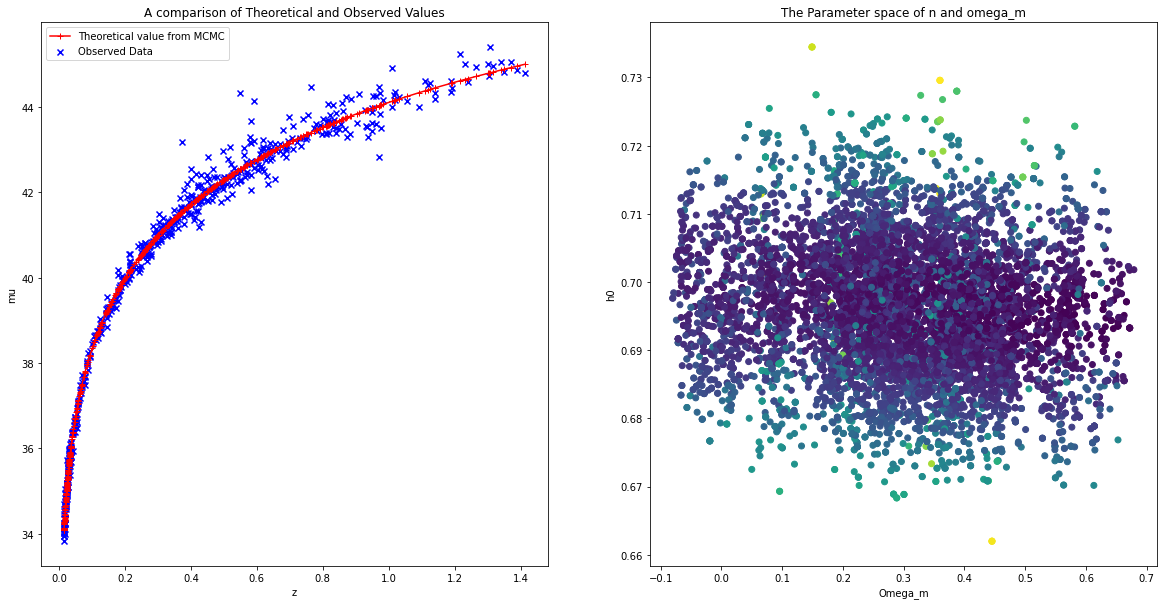

In [19]:
#For value calculation, we reject the initial values given by the algorithm so as to only select the values where the algorithm converges(as taught in class)
#Lets say we reject the initial 25% of the values
reject= 100

print ('\n\n\nEstimated value of omega_m = '+ str(np.mean(mcmc_arr[reject:sampl,0])))
print ('Estimated value of n = '+ str(np.mean(mcmc_arr[reject:sampl,1])))
print ('Estimated value of standard deviation of omega_m = '+ str(np.std(mcmc_arr[reject:sampl,0])))
print ('Estimated value of standard deviation of  n = '+ str(np.std(mcmc_arr[reject:sampl,1])))
print ('Estimated value of h0 = '+ str(np.mean(mcmc_arr[reject:sampl,2])))
print ('Estimated value of standard deviation of h0 = '+ str(np.std(mcmc_arr[reject:sampl,2])))
print ('Acceptance ratio is '+ str((accpt_nmbr*100)/sampl)+"  percent")
print(np.amin(mcmc_arr[reject:sampl,3]))
fig = plt.figure()
fig.set_size_inches(20,10)
#Plot the samples
ax1 = fig.add_subplot(121)
plt.xlabel("z")
plt.ylabel('mu')
plt.title("A comparison of Theoretical and Observed Values")
ax1.scatter(z, mu, c='blue', marker='x',label="Observed Data")
ax2 = fig.add_subplot(122)
ax2.scatter(mcmc_arr[reject:,1], mcmc_arr[reject:,2],c = -mcmc_arr[reject:,3])
#plt.xlim(0.1,0.5)
#plt.ylim(0.6,0.8)
plt.xlabel("Omega_m")
plt.ylabel('h0')


#To plot the z vs mu function for out theoretical values
y_theoretical=np.empty(len(z))
for i in range(len(z)):
    y_theoretical[i]= mu_theory(z[i], np.mean(mcmc_arr[reject:,0]), np.mean(mcmc_arr[reject:,1]),np.mean(mcmc_arr[reject:,2]))
ax1.plot(z, y_theoretical, c='red', marker='+',label="Theoretical value from MCMC")
ax1.legend()
plt.title("The Parameter space of n and omega_m")
plt.show() 

In [23]:
(mcmc_arr[reject:sampl,3]).reshape(99,100)

array([[-524.27925454, -524.27925454, -524.28565495, ..., -525.88661431,
        -526.78006696, -524.95121828],
       [-524.95121828, -524.29643953, -523.70688699, ..., -524.7413546 ,
        -523.82651933, -524.23924713],
       [-524.4078836 , -524.09973853, -524.09973853, ..., -525.35536973,
        -525.35536973, -525.48024427],
       ...,
       [-524.84406996, -524.73057299, -524.62371034, ..., -524.44614409,
        -524.21579089, -524.21579089],
       [-523.91736575, -523.53001858, -523.55196212, ..., -525.08415566,
        -525.65044304, -524.88805332],
       [-524.88805332, -524.88805332, -524.88805332, ..., -523.8370947 ,
        -523.96115179, -523.96115179]])

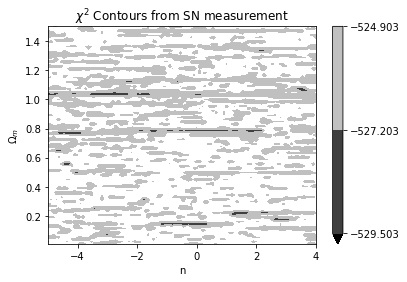

In [24]:
n= np.linspace(-5,4,100)
omega_m =np.linspace(0.01,1.5,99)
t1=(mcmc_arr[reject:sampl,3]).reshape(99,100)
#fig,ax=plt.subplots(1,1)
levels = np.array([np.amin((mcmc_arr[reject:sampl,3]))+2.3, np.amin((mcmc_arr[reject:sampl,3]))+2*2.3, np.amin((mcmc_arr[reject:sampl,3]))+3*2.3])
contours =plt.contourf(n,omega_m, t1,levels=levels, extend='min',cmap = 'gist_gray')
plt.xlabel('n')
plt.ylabel('$\Omega_m$')
plt.rcParams["figure.figsize"] = (5,5)
plt.title("$\chi^2$ Contours from SN measurement")
#plt.clabel(contours, inline=True, fontsize=8, colors='b')
#cp.set_clim(vmin=560,vmax=600)
#cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
plt.colorbar() # Add a colorbar to a plot
#plt.clim(0, 150) 

In [62]:
print(sort_data_SN.Z_SN[0])
print(z[0])

0.028488
0.028488


Text(0.5, 0, 'steps')

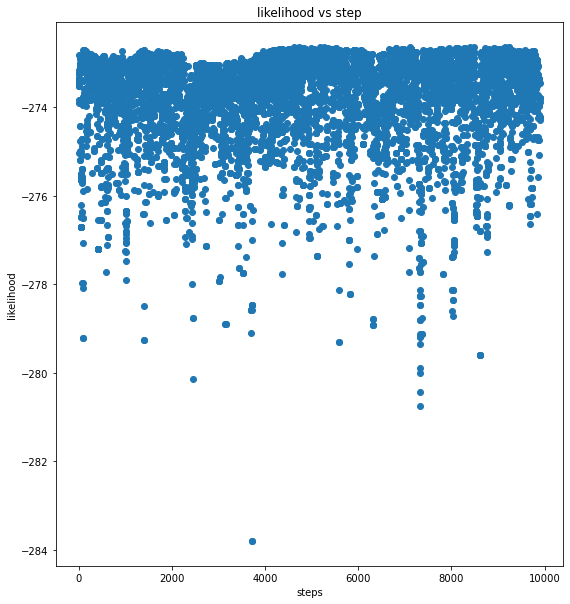

In [48]:
reject= 100
fig = plt.figure()
fig.set_size_inches(20,10)
b=np.linspace(1,sampl-reject,sampl-reject)
#Plot the samples
ax2 = fig.add_subplot(121)
ax2.scatter(b, mcmc_arr[reject:sampl,3])
plt.title("likelihood vs step")
plt.ylabel("likelihood")
plt.xlabel('steps')


MCMC for omega_m,n for SN events

In [25]:
#omega_m,n SN
#number of samples 
sampl= 10000
#number of pars
par = 2

inv_cov_mat= np.linalg.inv(cov_mat)
#assume the parameters have a gaussian distribution
sigma_omega= 0.01
sigma_n= 0.01
omega_b0 = 0.0000245
omega_r0=0.02
h0=69.8
#Defining part which comes inside integeration of distance Luminosity


dmthSN= np.zeros(len(z))
dlthSN = np.zeros(len(z))
dldataSN=np.zeros(len(z))
error= np.zeros(len(z))
dlerror= np.zeros(len(z))

a=b=c=d=e=0
# DL theoretical from VCG model
def D_l(z,omega_m,n):
    def int_func(x):
        return 1/((pow((1+x),2)*(omega_r0+(omega_b0/(1+x))+((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+z)**n)**(0.5)/(1+x)**(4)))**(0.5)))
    g = quad(int_func,0,z)
    return (1+z)*g[0]*(300000/(h0))
#Function to calculate the value of mu_theory
def mu_theory(z,omega_m,n):
        m=5*log(D_l(z,omega_m,n),10)+25
        return m


# We now defile a likelihood function as given in the notes
# If the value comes out to be less than zero, set it to a very very small likelyhood
#Temporary variable to store mu(observation)- mu(theory)
dmu= np.empty(len(z))
def lnl(omega_m, n):
    if(omega_m<=0.0):
        loglikely=-1.e100
    else:
        for i in range(len(z)):
            dmu[i]= mu[i]- mu_theory(z[i],omega_m,n)
        loglikely= -0.5*np.dot(dmu,np.dot(inv_cov_mat,dmu))
    return loglikely



#Empty array to store parameter values
# First Column = Omega_m
# Second Column = n

# A third parameter will be used to store the ln(likelihood) 

# Create a [1000,3] empty array
mcmc_arr= np.empty([sampl,par+1])

#Set initial likelyhood to a very low value so that next likelihood calculated is greater than 
#that and is accepted
#Filling up the first row of the three columns
mcmc_arr[0,0]= np.random.uniform()
mcmc_arr[0,1]= np.random.uniform()

#Calculate an initial likelyhood value and store it as the third column
mcmc_arr[0,2]=lnl(mcmc_arr[0,0], mcmc_arr[0,1])
accpt_nmbr=0

for i in range(1,sampl):
    lnl_prev= mcmc_arr[i-1,2]
    omega_m_next= np.random.normal(mcmc_arr[i-1,0],sigma_omega)
    n_next= np.random.normal(mcmc_arr[i-1,1],sigma_n)

    lnl_next= lnl(omega_m_next,n_next)

    #Now comes the Metropolis Hastings algorithm to accept or reject the newly calculated point
    # Accept the point if likelyhood has increased
    if(lnl_next>lnl_prev):
        mcmc_arr[i,0]= omega_m_next
        mcmc_arr[i,1]= n_next
        mcmc_arr[i,2]= lnl_next
        accpt_nmbr+=1
        #print("Accepted with a higher likelihood")
    else:
        x=np.random.uniform()
        #if not, we accept it with a lesser likelyhood defined by a threshold
        if(lnl_next-lnl_prev>np.log(x)): 
#This can be randomized everytime to select a different threshold, select a value x=np.random.uniform() 
#and take log(x)
            mcmc_arr[i,0]= omega_m_next
            mcmc_arr[i,1]= n_next
            mcmc_arr[i,2]= lnl_next
            accpt_nmbr+=1
            #print("Accepted with a lesser likelihood")
        else:
            mcmc_arr[i,0]= mcmc_arr[i-1,0]
            mcmc_arr[i,1]= mcmc_arr[i-1,1]
            mcmc_arr[i,2]= lnl_prev
            #print("This draw is rejected")




Estimated value of omega_m = 0.1689478578626847
Estimated value of n = -0.12554964275858288
Estimated value of standard deviation of omega_m = 0.03263355074726924
Estimated value of standard deviation of  n = 0.25231333908619474
Acceptance ratio is 86.92  percent


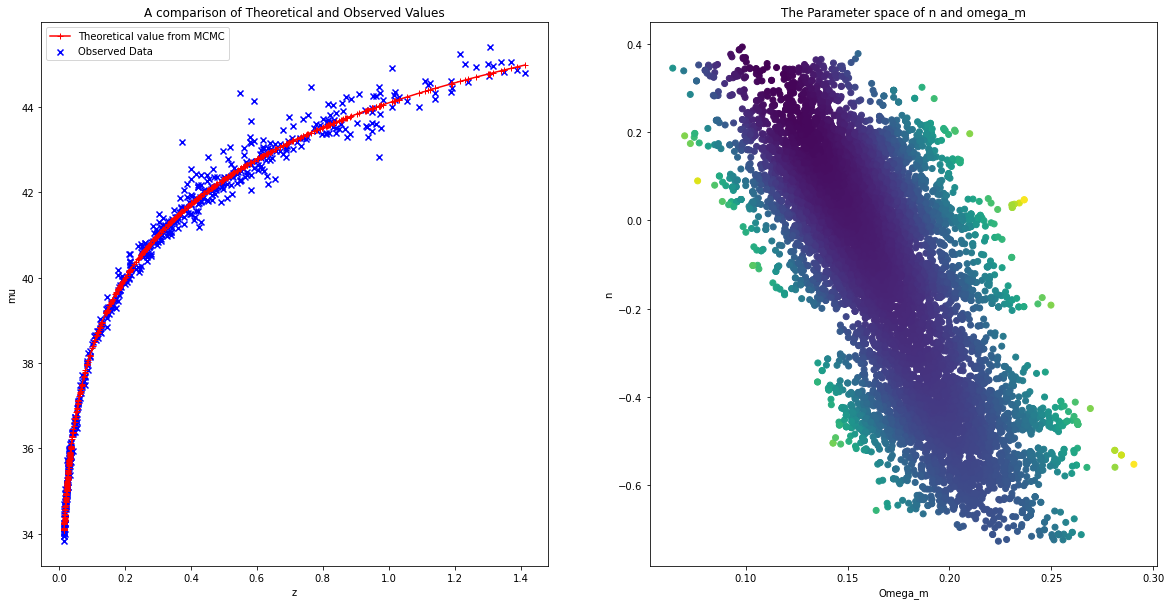

In [26]:
#For value calculation, we reject the initial values given by the algorithm so as to only select the values where the algorithm converges(as taught in class)
#Lets say we reject the initial 25% of the values
reject= sampl//25

print ('\n\n\nEstimated value of omega_m = '+ str(np.mean(mcmc_arr[reject:sampl,0])))
print ('Estimated value of n = '+ str(np.mean(mcmc_arr[reject:sampl,1])))
print ('Estimated value of standard deviation of omega_m = '+ str(np.std(mcmc_arr[reject:sampl,0])))
print ('Estimated value of standard deviation of  n = '+ str(np.std(mcmc_arr[reject:sampl,1])))
print ('Acceptance ratio is '+ str((accpt_nmbr*100)/sampl)+"  percent")

fig = plt.figure()
fig.set_size_inches(20,10)
#Plot the samples
ax1 = fig.add_subplot(121)
plt.xlabel("z")
plt.ylabel('mu')
plt.title("A comparison of Theoretical and Observed Values")
ax1.scatter(z, mu, c='blue', marker='x',label="Observed Data")
ax2 = fig.add_subplot(122)
ax2.scatter(mcmc_arr[reject:,0], mcmc_arr[reject:,1],c = -mcmc_arr[reject:,2])
#plt.xlim(0.1,0.5)
#plt.ylim(0.6,0.8)
plt.xlabel("Omega_m")
plt.ylabel('n')


#To plot the z vs mu function for out theoretical values
y_theoretical=np.empty(len(z))
for i in range(len(z)):
    y_theoretical[i]= mu_theory(z[i], np.mean(mcmc_arr[reject:,0]), np.mean(mcmc_arr[reject:,1]))
ax1.plot(z, y_theoretical, c='red', marker='+',label="Theoretical value from MCMC")
ax1.legend()
plt.title("The Parameter space of n and omega_m")
plt.show() 

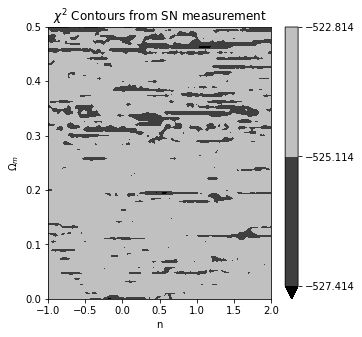

In [33]:
n= np.linspace(-1,2,100)
omega_m =np.linspace(0,.5,96)
t1=(mcmc_arr[reject:sampl,2]).reshape(96,100)
#fig,ax=plt.subplots(1,1)
levels = np.array([np.amin((mcmc_arr[reject:sampl,2]))+2.3, np.amin((mcmc_arr[reject:sampl,2]))+2*2.3, np.amin((mcmc_arr[reject:sampl,2]))+3*2.3])
contours =plt.contourf(n,omega_m, t1,levels=levels, extend='min',cmap = 'gist_gray')
plt.xlabel('n')
plt.ylabel('$\Omega_m$')
plt.rcParams["figure.figsize"] = (5,5)
plt.title("$\chi^2$ Contours from SN measurement")
#plt.clabel(contours, inline=True, fontsize=8, colors='b')
#cp.set_clim(vmin=560,vmax=600)
#cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
plt.colorbar() # Add a colorbar to a plot
#plt.clim(0, 150) 

MCMC for h0 for SN events

In [43]:
#number of samples 
sampl= 10000
#number of pars
par = 2


#assume the parameters have a gaussian distribution
sigma_omega= 0.01
sigma_n= 0.01
omega_b0 = 0.0000245
omega_r0=0.02
omega_m=0.30
n=0.27

#Defining part which comes inside integeration of distance Luminosity

inv_cov_mat= np.linalg.inv(cov_mat)
dmthSN= np.zeros(len(z))
dlthSN = np.zeros(len(z))
dldataSN=np.zeros(len(z))
error= np.zeros(len(z))
dlerror= np.zeros(len(z))

a=b=c=d=e=0
# DL theoretical from VCG model
def D_l(z,h0):
    def int_func(x):
        return 1/((pow((1+x),2)*(omega_r0+(omega_b0/(1+x))+((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+z)**n)**(0.5)/(1+x)**(4)))**(0.5)))
    g = quad(int_func,0,z)
    return (1+z)*g[0]*(3000/(h0))
#Function to calculate the value of mu_theory
def mu_theory(z,h0):
        m=5*log(D_l(z,h0),10)+25
        return m


# We now defile a likelihood function as given in the notes
# If the value comes out to be less than zero, set it to a very very small likelyhood
#Temporary variable to store mu(observation)- mu(theory)
dmu= np.empty(len(z))
def lnl(h0):
    if(h0<=0.0 or h0>=1.0):
        loglikely=-1.e100
    else:
        for i in range(len(z)):
            dmu[i]= mu[i]- mu_theory(z[i],h0)
        loglikely= -0.5*np.dot(dmu,np.dot(inv_cov_mat,dmu))
    return loglikely



#Empty array to store parameter values
# First Column = Omega_m
# Second Column = n

# A third parameter will be used to store the ln(likelihood) 

# Create a [1000,3] empty array
mcmc_arr= np.empty([sampl,par+1])

#Set initial likelyhood to a very low value so that next likelihood calculated is greater than 
#that and is accepted
#Filling up the first row of the three columns
mcmc_arr[0,0]= np.random.uniform()

#Calculate an initial likelyhood value and store it as the third column
mcmc_arr[0,1]=lnl(mcmc_arr[0,0])
accpt_nmbr=0

for i in range(1,sampl):
    lnl_prev= mcmc_arr[i-1,1]
    h0_next= np.random.normal(mcmc_arr[i-1,0],sigma_omega)

    lnl_next= lnl(h0_next)

    #Now comes the Metropolis Hastings algorithm to accept or reject the newly calculated point
    # Accept the point if likelyhood has increased
    if(lnl_next>lnl_prev):
        mcmc_arr[i,0]= h0_next
        mcmc_arr[i,1]= lnl_next
        accpt_nmbr+=1
        #print("Accepted with a higher likelihood")
    else:
        x=np.random.uniform()
        #if not, we accept it with a lesser likelyhood defined by a threshold
        if(lnl_next-lnl_prev>np.log(x)): 
#This can be randomized everytime to select a different threshold, select a value x=np.random.uniform() 
#and take log(x)
            mcmc_arr[i,0]= h0_next
            mcmc_arr[i,1]= lnl_next
            accpt_nmbr+=1
            #print("Accepted with a lesser likelihood")
        else:
            mcmc_arr[i,0]= mcmc_arr[i-1,0]
            mcmc_arr[i,1]= lnl_prev
            #print("This draw is rejected")




Estimated value of H0 = 0.6759633316082588
Estimated value of standard deviation of H0 = 0.006779778764122966
Acceptance ratio is 58.27  percent


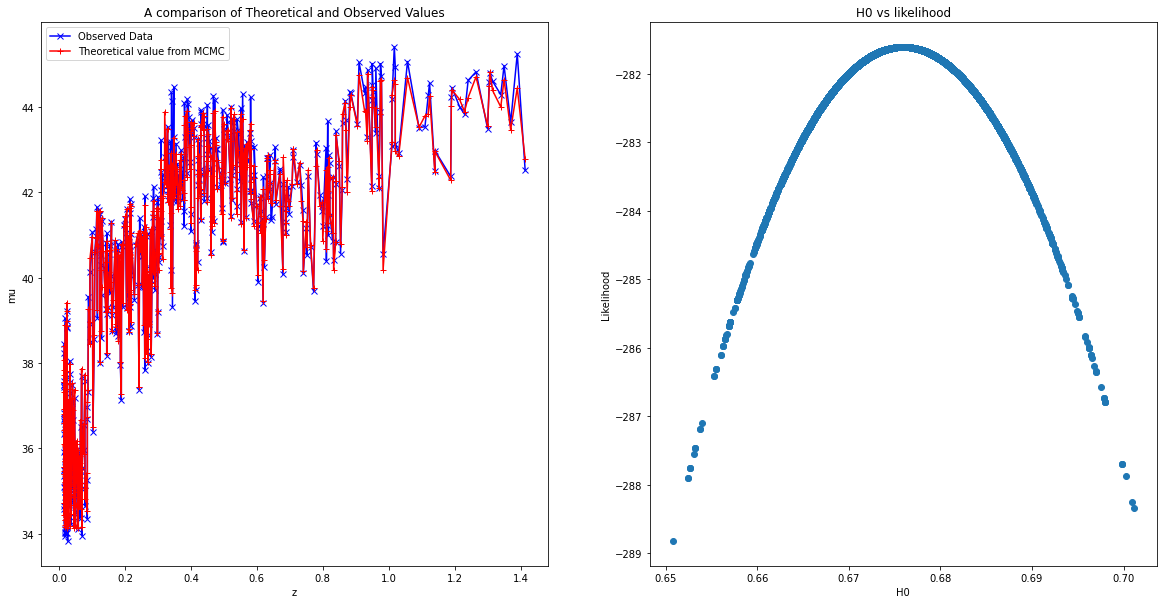

In [44]:
#For value calculation, we reject the initial values given by the algorithm so as to only select the values where the algorithm converges(as taught in class)
#Lets say we reject the initial 25% of the values
reject= sampl//25

print ('\n\n\nEstimated value of H0 = '+ str(np.mean(mcmc_arr[reject:sampl,0])))
print ('Estimated value of standard deviation of H0 = '+ str(np.std(mcmc_arr[reject:sampl,0])))
print ('Acceptance ratio is '+ str((accpt_nmbr*100)/sampl)+"  percent")

fig = plt.figure()
fig.set_size_inches(20,10)
#Plot the samples
ax1 = fig.add_subplot(121)
plt.xlabel("z")
plt.ylabel('mu')
plt.title("A comparison of Theoretical and Observed Values")
ax1.plot(z, mu, c='blue', marker='x',label="Observed Data")
ax2 = fig.add_subplot(122)
ax2.scatter(mcmc_arr[reject:,0], mcmc_arr[reject:,1])
#plt.xlim(0.1,0.5)
#plt.ylim(0.6,0.8)
plt.xlabel("H0")
plt.ylabel('Likelihood')


#To plot the z vs mu function for out theoretical values
y_theoretical=np.empty(len(z))
for i in range(len(z)):
    y_theoretical[i]= mu_theory(z[i], np.mean(mcmc_arr[reject:,0]))
ax1.plot(z, y_theoretical, c='red', marker='+',label="Theoretical value from MCMC")
ax1.legend()
plt.title("H0 vs likelihood")
plt.show() 

# Collecting GW events

In [5]:
name=np.array(['GW190521','GW190706_222641','GW190413_134308','GW190514_065416','GW190719_215514','GW190521',"GW190909_114149","GW190413_052954",'GW190803_022701','GW190731_140936','GW190727_060333','GW190620_030421','GW190421_213856','GW170729','GW190602_175927','GW190527_092055','GW190519_153544','GW190424_180648','GW190929_012149','GW190828_063405','GW190701_203306','GW190513_205428','GW170823','GW190517_055101','GW190915_235702','GW190828_065509','GW190408_181802','GW190910_112807','GW190512_180714','GW190503_185404','GW190521_074359','GW170818','GW151012','GW170809','GW170104','GW190728_064510','GW190708_232457','GW190630_185205','GW190720_000836','GW190707_093326','GW190930_133541','GW190412','GW190924_021846','GW170814','GW151226','GW150914','GW190426_152155','GW200115_042309','GW170608','GW200105_162426','GW190814','GW190425','GW170817'])
full_DL_GW=np.array([[5300.0,2400,-2600],[4420.0,2590,-1930],[4450,2480,-2120],[4130.0,2650,-2170],[3940.0,2590,-2000],[3920.0,2190,-1950],[3770.0,3270,-2220],[3550.0,2270,-1660],[3270.0,1950,-1580],[3300.0,2390,-1720],[3300.0,1540,-1500],[2810.0,1680,-1310],[2880.0,1370,-1380],[2840.0,1400,-1360],[2690.0,1790,-1120],[2490.0,2480,-1240],[2530.0,1830,-920],[2200.0,1580,-1160],[2130.0,3650,-1050],[2130.0,660,-930],[2060.0,760,-730],[2060.0,880,-800],[1940.0,970,-900],[1860.0,1620,-840],[1620.0,710,-610],[1600.0,620,-600],[1550.0,400,-600],[1460.0,1030,-580],[1430.0,550,-550],[1450.0,690,-630],[1240.0,400,-570],[1060.0,420,-380],[1080.0,550,-490],[1030.0,320,-390],[990.0,440,-430],[870.0,260,-370],[880.0,330,-390],[890.0,560,-370],[790.0,690,-320],[770.0,380,-370],[760.0,360,-320],[740.0,140,-170],[570.0,220,-220],[600.0,150,-220],[450.0,180,-190],[440.0,150,-170],[370.0,180,-160],[300.0,150,-100],[320.0,120,-110],[280.0,110,-110],[241.0,41,-45],[159.0,69,-72],[40.0,7,-15]])
full_Z_GW=np.array([[0.82,0.28,-0.34],[0.71,0.32,-0.27],[0.71,0.31,-0.30],[0.67,0.33,-0.31],[0.64,0.33,-0.29],[0.64,0.28,-0.28],[0.62,0.41,-0.33],[0.59,0.29,-0.24],[0.55,0.26,-0.24],[0.55,0.31,-0.26],[0.55,0.21,-0.22],[0.49,0.23,-0.20],[0.49,0.19,-0.21],[0.49,0.19,-0.21],[0.47,0.25,-0.17],[0.44,0.34,-0.20],[0.44,0.25,-0.14],[0.39,0.23,-0.19],[0.38,0.49,-0.17],[0.38,0.10,-0.15],[0.37,0.11,-0.12],[0.37,0.13,-0.13],[0.35,0.15,-0.15],[0.34,0.24,-0.14],[0.3,0.11,-0.10],[0.3,0.10,-0.10],[0.29,0.06,-0.10],[0.28,0.16,-0.10],[0.27,0.09,-0.10],[0.27,0.11,-0.11],[0.24,0.07,-0.10],[0.21,0.07,-0.07],[0.21,0.09,-0.09],[0.2,0.05,-0.07],[0.2,0.08,-0.08],[0.18,0.05,-0.07],[0.18,0.06,-0.07],[0.18,0.10,-0.07],[0.16,0.12,-0.06],[0.16,0.07,-0.07],[0.15,0.06,-0.06],[0.15,0.03,-0.03],[0.12,0.04,-0.04],[0.12,0.03,-0.04],[0.09,0.04,-0.04],[0.09,0.03,-0.03],[0.08,0.04,-0.03],[0.07,0.03,-0.02],[0.07,0.02,-0.02],[0.06,0.02,-0.02],[0.053,0.009,-0.010],[0.04,0.01,-0.02],[0.01,0.00,-0.00]])
# Number of events
a=name.size

#Defining arrays
dldata_GW=np.zeros(a)
dlUP=np.zeros(a)
dlLOW=np.zeros(a)
dlTOP=np.zeros(a)
dlBOTTOM=np.zeros(a)
dmtop=np.zeros(a)
dmbottom=np.zeros(a)
Z_GW=np.zeros(a)
dmth_GW=np.zeros(a)
dmdata_GW=np.zeros(a)
dlth_GW = np.zeros(a)
dmtoperr=np.zeros(a)
dmbottomerr=np.zeros(a)
#defining variables for index of the above arrays
b=c=d=e=f=h=k=l=m=x=y=p=q=r=s=0
#extracting redshifts and DL from the full data
for i in full_Z_GW:
  Z_GW[e]+=i[0]
  e+=1
for i in full_DL_GW:
  dldata_GW[b]+=i[0]
  b+=1
for i in dldata_GW:
  dmdata_GW[h]+=5*log(i,10)+25
  h+=1
for i in full_DL_GW:
  dlUP[c]+=i[0]+i[1]
  c+=1
for i in full_DL_GW:
  dlLOW[d]+=i[0]+i[2]
  d+=1
label1 = {"Event_Name":name,"Z_GW":Z_GW,"dLdata_GW":dldata_GW,"DMdata_GW": dmdata_GW,"DL_Uplimit": dlUP, "DL_Lowlimit": dlLOW}
data_GW=pd.DataFrame(label1)
data_GWTC3 = pd.read_excel (r'/root/Github_Repos/VCG_GW/oldGW.xlsx')
data_GWTC3.index= np.arange(53,88)

mucollect=[data_GW.Z_GW,data_GWTC3.redshift]
z1 = pd.concat(mucollect)

namecollect=[data_GW.Event_Name,data_GWTC3.Event_Name_GWTC3]
finalevents = pd.concat(namecollect)

dlcollect=[data_GW.dLdata_GW,data_GWTC3.luminosity_distance]
finaldl1 = pd.concat(dlcollect)

dlupcollect=[data_GW.DL_Uplimit,data_GWTC3.luminosity_distance_upper]
finaldlup1 = pd.concat(dlupcollect)

dllowcollect=[data_GW.DL_Lowlimit,data_GWTC3.luminosity_distance_lower]
finaldllow1 = pd.concat(dllowcollect)
label2 = {"EventName":finalevents,"ZGW":z1,"dLdataGW":finaldl1,"DLUplimit":finaldlup1,"DLLowlimit":finaldllow1}
Final_GW=pd.DataFrame(label2)
sort_data_GW=Final_GW.sort_values(by=['ZGW'],ignore_index=True)

z=sort_data_GW.ZGW
finaldl=sort_data_GW.dLdataGW
finaldlup=sort_data_GW.DLUplimit
finaldllow=sort_data_GW.DLLowlimit
a=finalevents.size

#Defining arrays
dlTOP=np.zeros(a)
dlBOTTOM=np.zeros(a)
dmtop=np.zeros(a)
dmbottom=np.zeros(a)
dmth3_GW=np.zeros(a)
mu=np.zeros(a)
dlth3_GW = np.zeros(a)
dmtoperr=np.zeros(a)
dmbottomerr=np.zeros(a)
#defining variables for index of the above arrays
f=h=k=l=m=x=y=p=q=r=s=0

for i in finaldl:
  mu[h]+=5*log(i,10)+25
  h+=1
for i in finaldlup:
  dmtop[f]+=5*log(i,10)+25
  f+=1
for i in finaldllow:
  dmbottom[k]+=5*log(i,10)+25
  k+=1
#upper and lower differences for errors
for (i,j) in zip(mu,dmtop):
  dmtoperr[r]+=j-i
  r+=1
for (i,j) in zip(mu,dmbottom):
  dmbottomerr[s]+=i-j
  s+=1

# MCMC of omega_m, n, H0 for GW events

In [8]:
#number of samples 
sampl= 10000
#number of pars
par = 2

sigma=(dmtoperr+dmbottomerr)/2
#assume the parameters have a gaussian distribution
sigma_omega= 0.01
sigma_n= 0.01
omega_b0 = 0.0000245
omega_r0=0.02


#Defining part which comes inside integeration of distance Luminosity


dmthSN= np.zeros(len(z))
dlthSN = np.zeros(len(z))
dldataSN=np.zeros(len(z))
error= np.zeros(len(z))
dlerror= np.zeros(len(z))

a=b=c=d=e=0
# DL theoretical from VCG model
def D_l(z,omega_m,n,h0):
    def int_func(x):
        return 1/(pow((1+x),2)*(omega_r0+(omega_b0/(1+x))+((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+z)**n)**(0.5)/(1+x)**(4)))**(0.5))
    g = quad(int_func,0,z)
    return (1+z)*g[0]*(3000/(h0))
#Function to calculate the value of mu_theory
def mu_theory(z,omega_m,n,h0):
        m=5*log(D_l(z,omega_m,n,h0),10)+25
        return m


# We now defile a likelihood function as given in the notes
# If the value comes out to be less than zero, set it to a very very small likelyhood
#Temporary variable to store mu(observation)- mu(theory)
dmu= np.empty(len(z))
def lnl(omega_m, n,h0):
        if(omega_m<=0.0 or omega_m>=1 or h0<0):
            loglikely=-1.e100
        else:
            for i in range(len(z)):
                dmu[i]= mu[i]- mu_theory(z[i],omega_m,n,h0)
            loglikely= -0.5*np.dot(dmu,dmu)/np.dot(sigma,sigma)
        return loglikely



#Empty array to store parameter values
# First Column = Omega_m
# Second Column = n

# A third parameter will be used to store the ln(likelihood) 

# Create a [1000,3] empty array
mcmc_arr= np.empty([sampl,par+2])

#Set initial likelyhood to a very low value so that next likelihood calculated is greater than 
#that and is accepted
#Filling up the first row of the three columns
mcmc_arr[0,0]= np.random.uniform()
mcmc_arr[0,1]= np.random.uniform()
mcmc_arr[0,2]= np.random.uniform()
#Calculate an initial likelyhood value and store it as the third column
mcmc_arr[0,3]=lnl(mcmc_arr[0,0], mcmc_arr[0,1],mcmc_arr[0,2])
accpt_nmbr=0

for i in range(1,sampl):
    lnl_prev= mcmc_arr[i-1,3]
    omega_m_next= np.random.normal(mcmc_arr[i-1,0],sigma_omega)
    n_next= np.random.normal(mcmc_arr[i-1,1],sigma_n)
    h0_next=np.random.normal(mcmc_arr[i-1,2],sigma_n)
    lnl_next= lnl(omega_m_next,n_next,h0_next)

    #Now comes the Metropolis Hastings algorithm to accept or reject the newly calculated point
    # Accept the point if likelyhood has increased
    if(lnl_next>lnl_prev):
        mcmc_arr[i,0]= omega_m_next
        mcmc_arr[i,1]= n_next
        mcmc_arr[i,2]= h0_next
        mcmc_arr[i,3]= lnl_next
        accpt_nmbr+=1
        #print("Accepted with a higher likelihood")
    else:
        x=np.random.uniform()
        #if not, we accept it with a lesser likelyhood defined by a threshold
        if(lnl_next-lnl_prev>np.log(x)): 
#This can be randomized everytime to select a different threshold, select a value x=np.random.uniform() 
#and take log(x)
            mcmc_arr[i,0]= omega_m_next
            mcmc_arr[i,1]= n_next
            mcmc_arr[i,2]= h0_next
            mcmc_arr[i,3]= lnl_next
            accpt_nmbr+=1
            #print("Accepted with a lesser likelihood")
        else:
            mcmc_arr[i,0]= mcmc_arr[i-1,0]
            mcmc_arr[i,1]= mcmc_arr[i-1,1]
            mcmc_arr[i,2]= mcmc_arr[i-1,2]
            mcmc_arr[i,3]= lnl_prev
            #print("This draw is rejected")




Estimated value of omega_m = 0.6124782139151155
Estimated value of n = 0.10770446209318411
Estimated value of standard deviation of omega_m = 0.14140894802316437
Estimated value of standard deviation of  n = 0.26862264814145104
Estimated value of h0 = 0.5995365500643524
Estimated value of standard deviation of h0 = 0.16511408579528936
Acceptance ratio is 98.84  percent


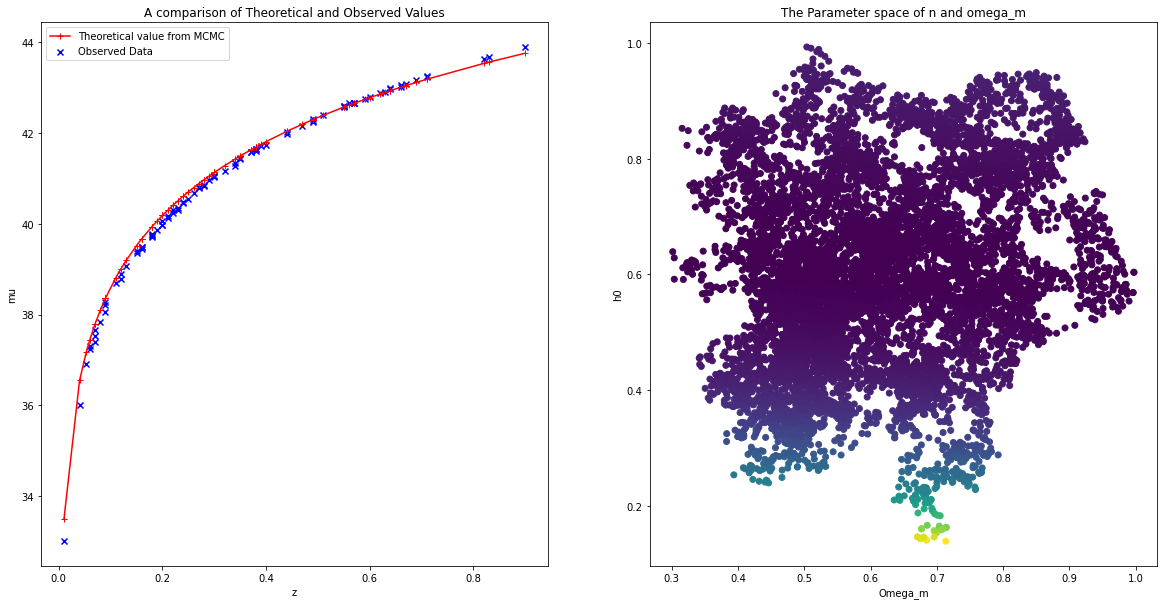

In [11]:
#For value calculation, we reject the initial values given by the algorithm so as to only select the values where the algorithm converges(as taught in class)
#Lets say we reject the initial 25% of the values
reject= 900

print ('\n\n\nEstimated value of omega_m = '+ str(np.mean(mcmc_arr[reject:sampl,0])))
print ('Estimated value of n = '+ str(np.mean(mcmc_arr[reject:sampl,1])))
print ('Estimated value of standard deviation of omega_m = '+ str(np.std(mcmc_arr[reject:sampl,0])))
print ('Estimated value of standard deviation of  n = '+ str(np.std(mcmc_arr[reject:sampl,1])))
print ('Estimated value of h0 = '+ str(np.mean(mcmc_arr[reject:sampl,2])))
print ('Estimated value of standard deviation of h0 = '+ str(np.std(mcmc_arr[reject:sampl,2])))
print ('Acceptance ratio is '+ str((accpt_nmbr*100)/sampl)+"  percent")
fig = plt.figure()
fig.set_size_inches(20,10)
#Plot the samples
ax1 = fig.add_subplot(121)
plt.xlabel("z")
plt.ylabel('mu')
plt.title("A comparison of Theoretical and Observed Values")
ax1.scatter(z, mu, c='blue', marker='x',label="Observed Data")
ax2 = fig.add_subplot(122)
ax2.scatter(mcmc_arr[reject:,0], mcmc_arr[reject:,2],c = -mcmc_arr[reject:,3])
#plt.xlim(0.1,0.5)
#plt.ylim(0.6,0.8)
plt.xlabel("Omega_m")
plt.ylabel('h0')



#To plot the z vs mu function for out theoretical values
y_theoretical=np.empty(len(z))
for i in range(len(z)):
    y_theoretical[i]= mu_theory(z[i], np.mean(mcmc_arr[reject:,0]), np.mean(mcmc_arr[reject:,1]),np.mean(mcmc_arr[reject:,2]))
ax1.plot(z, y_theoretical, c='red', marker='+',label="Theoretical value from MCMC")
ax1.legend()
plt.title("The Parameter space of n and omega_m")
plt.show() 


MCMC of omega_m, n for GW events

In [69]:
#number of samples 
sampl= 10000
#number of pars
par = 2

sigma=(dmtoperr+dmbottomerr)/2
#assume the parameters have a gaussian distribution
sigma_omega= 0.01
sigma_n= 0.01
omega_b0 = 0.0000245
omega_r0=0.02
H0=69.8

#Defining part which comes inside integeration of distance Luminosity


dmthSN= np.zeros(len(z))
dlthSN = np.zeros(len(z))
dldataSN=np.zeros(len(z))
error= np.zeros(len(z))
dlerror= np.zeros(len(z))

a=b=c=d=e=0
# DL theoretical from VCG model
def D_l(z,omega_m,n):
    def int_func(x):
        return 1/((pow((1+x),2)*(omega_r0+(omega_b0/(1+x))+((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+z)**n)**(0.5)/(1+x)**(4)))**(0.5)))
    g = quad(int_func,0,z)
    return (1+z)*g[0]*(300000/(H0))
#Function to calculate the value of mu_theory
def mu_theory(z,omega_m,n):
        m=5*log(D_l(z,omega_m,n),10)+25
        return m


# We now defile a likelihood function as given in the notes
# If the value comes out to be less than zero, set it to a very very small likelyhood
#Temporary variable to store mu(observation)- mu(theory)
dmu= np.empty(len(z))
def lnl(omega_m, n):
    if(omega_m<=0.0 or omega_m>=1.0):
        loglikely=-1.e100
    else:
        for i in range(len(z)):
            dmu[i]= mu[i]- mu_theory(z[i],omega_m,n)
        loglikely= -0.5*np.dot(dmu,dmu)/np.dot(sigma,sigma)
    return loglikely



#Empty array to store parameter values
# First Column = Omega_m
# Second Column = n

# A third parameter will be used to store the ln(likelihood) 

# Create a [1000,3] empty array
mcmc_arr= np.empty([sampl,par+1])

#Set initial likelyhood to a very low value so that next likelihood calculated is greater than 
#that and is accepted
#Filling up the first row of the three columns
mcmc_arr[0,0]= np.random.uniform()
mcmc_arr[0,1]= np.random.uniform()

#Calculate an initial likelyhood value and store it as the third column
mcmc_arr[0,2]=lnl(mcmc_arr[0,0], mcmc_arr[0,1])
accpt_nmbr=0

for i in range(1,sampl):
    lnl_prev= mcmc_arr[i-1,2]
    omega_m_next= np.random.normal(mcmc_arr[i-1,0],sigma_omega)
    n_next= np.random.normal(mcmc_arr[i-1,1],sigma_n)

    lnl_next= lnl(omega_m_next,n_next)

    #Now comes the Metropolis Hastings algorithm to accept or reject the newly calculated point
    # Accept the point if likelyhood has increased
    if(lnl_next>lnl_prev):
        mcmc_arr[i,0]= omega_m_next
        mcmc_arr[i,1]= n_next
        mcmc_arr[i,2]= lnl_next
        accpt_nmbr+=1
        #print("Accepted with a higher likelihood")
    else:
        x=np.random.uniform()
        #if not, we accept it with a lesser likelyhood defined by a threshold
        if(lnl_next-lnl_prev>np.log(x)): 
#This can be randomized everytime to select a different threshold, select a value x=np.random.uniform() 
#and take log(x)
            mcmc_arr[i,0]= omega_m_next
            mcmc_arr[i,1]= n_next
            mcmc_arr[i,2]= lnl_next
            accpt_nmbr+=1
            #print("Accepted with a lesser likelihood")
        else:
            mcmc_arr[i,0]= mcmc_arr[i-1,0]
            mcmc_arr[i,1]= mcmc_arr[i-1,1]
            mcmc_arr[i,2]= lnl_prev
            #print("This draw is rejected")




Estimated value of omega_m = 0.7289692368656248
Estimated value of n = 0.2282079912939456
Estimated value of standard deviation of omega_m = 0.20530602654534758
Estimated value of standard deviation of  n = 0.2734555062735211
Acceptance ratio is 98.74  percent


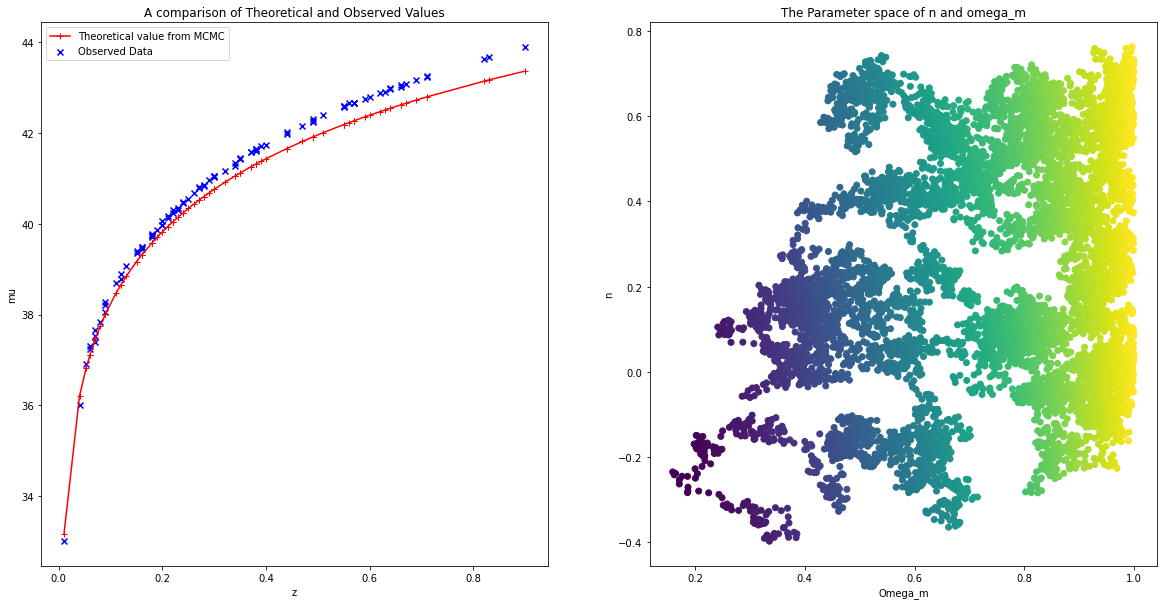

In [70]:
#For value calculation, we reject the initial values given by the algorithm so as to only select the values where the algorithm converges(as taught in class)
#Lets say we reject the initial 25% of the values
reject= sampl//25

print ('\n\n\nEstimated value of omega_m = '+ str(np.mean(mcmc_arr[reject:sampl,0])))
print ('Estimated value of n = '+ str(np.mean(mcmc_arr[reject:sampl,1])))
print ('Estimated value of standard deviation of omega_m = '+ str(np.std(mcmc_arr[reject:sampl,0])))
print ('Estimated value of standard deviation of  n = '+ str(np.std(mcmc_arr[reject:sampl,1])))
print ('Acceptance ratio is '+ str((accpt_nmbr*100)/sampl)+"  percent")

fig = plt.figure()
fig.set_size_inches(20,10)
#Plot the samples
ax1 = fig.add_subplot(121)
plt.xlabel("z")
plt.ylabel('mu')
plt.title("A comparison of Theoretical and Observed Values")
ax1.scatter(z, mu, c='blue', marker='x',label="Observed Data")
ax2 = fig.add_subplot(122)
ax2.scatter(mcmc_arr[reject:,0], mcmc_arr[reject:,1],c = -mcmc_arr[reject:,2])
#plt.xlim(0.1,0.5)
#plt.ylim(0.6,0.8)
plt.xlabel("Omega_m")
plt.ylabel('n')


#To plot the z vs mu function for out theoretical values
y_theoretical=np.empty(len(z))
for i in range(len(z)):
    y_theoretical[i]= mu_theory(z[i], np.mean(mcmc_arr[reject:,0]), np.mean(mcmc_arr[reject:,1]))
ax1.plot(z, y_theoretical, c='red', marker='+',label="Theoretical value from MCMC")
ax1.legend()
plt.title("The Parameter space of n and omega_m")
plt.show() 




Estimated value of omega_m = 0.5927200120154046
Estimated value of n = 0.9010025324147934
Estimated value of standard deviation of omega_m = 0.2431165067832867
Estimated value of standard deviation of  n = 0.16312281382574678
Estimated value of h0 = 0.4973470480047897
Estimated value of standard deviation of h0 = 0.1759407815979459
Acceptance ratio is 97.28  percent


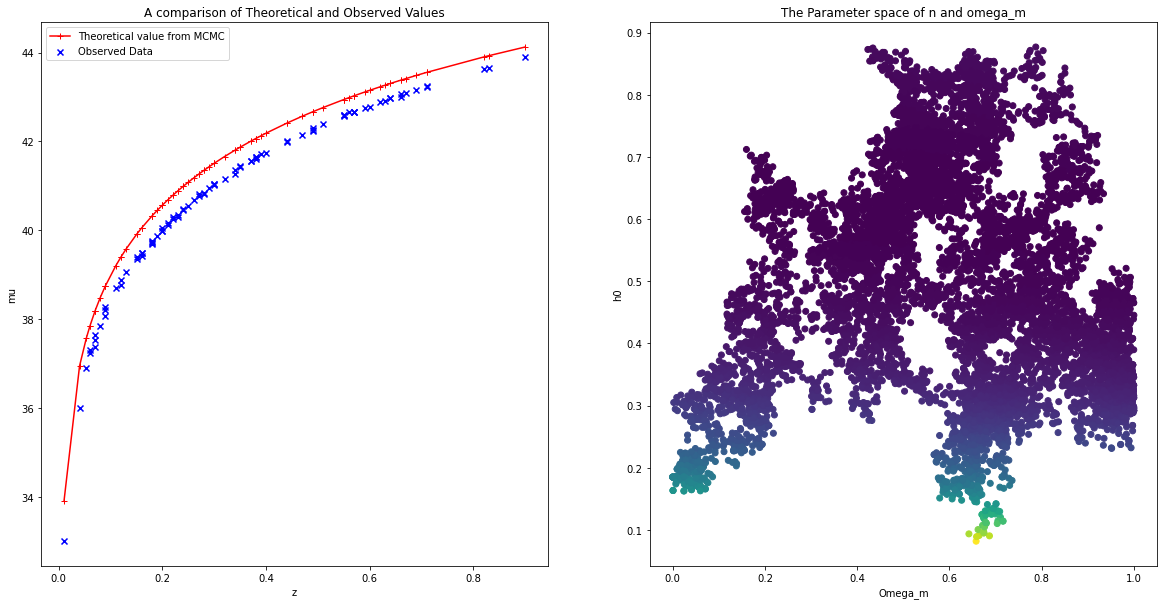

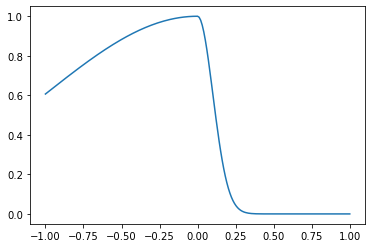

In [41]:
a=[]
b=[]
for x in np.linspace(0,1,100):
    lk=np.exp(-0.5*x**2/.01)
    a.append(lk)
a=np.array(a)  
for x in np.linspace(-1,0,100):
    lk=np.exp(-0.5*x**2/1)
    b.append(lk)
b=np.array(b) 
i=np.linspace(0,1,100)
j=np.linspace(-1,0,100)
f=np.concatenate((b,a))
totx=np.concatenate((j,i))
plt.plot(totx,f)  
#print(totx)

In [ ]:
#plt.style.use('seaborn-white')
n= np.linspace(-1.5,3,25)
omega_m =np.linspace(0.01,0.2,20)
np_array=np.asarray(col)
t1=np_array.reshape(20,25)
#fig,ax=plt.subplots(1,1)
levels = np.array([min(col)+2.3, min(col)+2*2.3, min(col)+3*2.3])
contours =plt.contourf(n,omega_m, t1,levels=levels, extend='min',cmap = 'gist_gray')
plt.xlabel('n')
plt.ylabel('$\Omega_m$')
plt.rcParams["figure.figsize"] = (5,5)
plt.title("$\chi^2$ Contours from SN measurement")
#plt.clabel(contours, inline=True, fontsize=8, colors='b')
#cp.set_clim(vmin=560,vmax=600)
#cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
plt.colorbar() # Add a colorbar to a plot
#plt.clim(0, 150) 

MCMC of H0 for GW events

In [82]:
#number of samples 
sampl= 10000
#number of pars
par = 2

sigma=(dmtoperr+dmbottomerr)/2
#assume the parameters have a gaussian distribution
sigma_omega= 0.01
sigma_n= 0.01
omega_b0 = 0.0000245
omega_r0=0.02
omega_m=0.592
n=0.901

#Defining part which comes inside integeration of distance Luminosity


dmthSN= np.zeros(len(z))
dlthSN = np.zeros(len(z))
dldataSN=np.zeros(len(z))
error= np.zeros(len(z))
dlerror= np.zeros(len(z))

a=b=c=d=e=0
# DL theoretical from VCG model
def D_l(z,h0):
    def int_func(x):
        return 1/((pow((1+x),2)*(omega_r0+(omega_b0/(1+x))+((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+z)**n)**(0.5)/(1+x)**(4)))**(0.5)))
    g = quad(int_func,0,z)
    return (1+z)*g[0]*(3000/(h0))
#Function to calculate the value of mu_theory
def mu_theory(z,h0):
        m=5*log(D_l(z,h0),10)+25
        return m


# We now defile a likelihood function as given in the notes
# If the value comes out to be less than zero, set it to a very very small likelyhood
#Temporary variable to store mu(observation)- mu(theory)



dmu= np.empty(len(z))
def lnl(h0):
    if(h0<=0.0 and h0>=1.0):
        loglikely=-1.e100
    else:
        for i in range(len(z)):
            dmu[i]= mu[i]- mu_theory(z[i],h0)
            loglikely= -0.5*np.dot(dmu,dmu)/np.dot(sigma,sigma)
    return loglikely

#Empty array to store parameter values
# First Column = Omega_m
# Second Column = n

# A third parameter will be used to store the ln(likelihood) 

# Create a [1000,3] empty array
mcmc_arr= np.empty([sampl,par+1])

#Set initial likelyhood to a very low value so that next likelihood calculated is greater than 
#that and is accepted
#Filling up the first row of the three columns
mcmc_arr[0,0]= np.random.uniform()

#Calculate an initial likelyhood value and store it as the third column
mcmc_arr[0,1]=lnl(mcmc_arr[0,0])
accpt_nmbr=0

for i in range(1,sampl):
    lnl_prev= mcmc_arr[i-1,1]
    h0_next= np.random.normal(mcmc_arr[i-1,0],sigma_omega)

    lnl_next= lnl(h0_next)

    #Now comes the Metropolis Hastings algorithm to accept or reject the newly calculated point
    # Accept the point if likelyhood has increased
    if(lnl_next>lnl_prev):
        mcmc_arr[i,0]= h0_next
        mcmc_arr[i,1]= lnl_next
        accpt_nmbr+=1
        #print("Accepted with a higher likelihood")
    else:
        x=np.random.uniform()
        #if not, we accept it with a lesser likelyhood defined by a threshold
        if(lnl_next-lnl_prev>np.log(x)): 
#This can be randomized everytime to select a different threshold, select a value x=np.random.uniform() 
#and take log(x)
            mcmc_arr[i,0]= h0_next
            mcmc_arr[i,1]= lnl_next
            accpt_nmbr+=1
            #print("Accepted with a lesser likelihood")
        else:
            mcmc_arr[i,0]= mcmc_arr[i-1,0]
            mcmc_arr[i,1]= lnl_prev
            #print("This draw is rejected")




Estimated value of H0 = 1.0205969559079584
Estimated value of standard deviation of H0 = 0.34306330195756285
Acceptance ratio is 99.44  percent


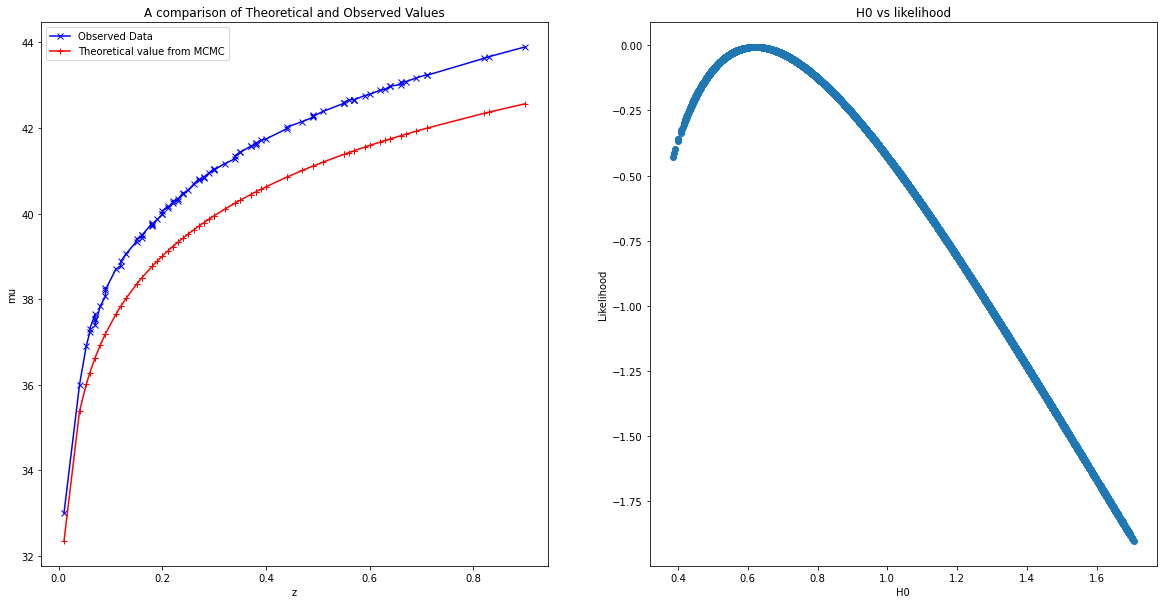

In [83]:
#For value calculation, we reject the initial values given by the algorithm so as to only select the values where the algorithm converges(as taught in class)
#Lets say we reject the initial 25% of the values
reject= 100

print ('\n\n\nEstimated value of H0 = '+ str(np.mean(mcmc_arr[reject:sampl,0])))
print ('Estimated value of standard deviation of H0 = '+ str(np.std(mcmc_arr[reject:sampl,0])))
print ('Acceptance ratio is '+ str((accpt_nmbr*100)/sampl)+"  percent")

fig = plt.figure()
fig.set_size_inches(20,10)
#Plot the samples
ax1 = fig.add_subplot(121)
plt.xlabel("z")
plt.ylabel('mu')
plt.title("A comparison of Theoretical and Observed Values")
ax1.plot(z, mu, c='blue', marker='x',label="Observed Data")
ax2 = fig.add_subplot(122)
ax2.scatter(mcmc_arr[reject:,0], mcmc_arr[reject:,1])
#plt.xlim(0.1,0.5)
#plt.ylim(0.6,0.8)
plt.xlabel("H0")
plt.ylabel('Likelihood')


#To plot the z vs mu function for out theoretical values
y_theoretical=np.empty(len(z))
for i in range(len(z)):
    y_theoretical[i]= mu_theory(z[i], np.mean(mcmc_arr[reject:,0]))
ax1.plot(z, y_theoretical, c='red', marker='+',label="Theoretical value from MCMC")
ax1.legend()
plt.title("H0 vs likelihood")
plt.show() 

In [32]:
#standard model
#number of samples 
sampl= 10000
#number of pars
par = 2


#assume the parameters have a gaussian distribution
sigma_omega= 0.01
sigma_n= 0.01
h0=69.8
#Defining part which comes inside integeration of distance Luminosity

inv_cov_mat= np.linalg.inv(cov_mat)
dmthSN= np.zeros(len(z))
dlthSN = np.zeros(len(z))
dldataSN=np.zeros(len(z))
error= np.zeros(len(z))
dlerror= np.zeros(len(z))

a=b=c=d=e=0
# DL theoretical from VCG model
def D_l(z,omega_r0,omega_m0):
    def int_func(x):
        return 1/(pow((1+x),2)*((1-omega_r0-omega_b0)/(1+x)**4+omega_r0+(omega_b0/(1+x))**(0.5)))
    g = quad(int_func,0,z)
    return (1+z)*g[0]*(300000/(h0))
#Function to calculate the value of mu_theory
def mu_theory(z,omega_r0,omega_m0):
        m=5*log(D_l(z,omega_r0,omega_m0),10)+25
        return m


# We now defile a likelihood function as given in the notes
# If the value comes out to be less than zero, set it to a very very small likelyhood
#Temporary variable to store mu(observation)- mu(theory)
dmu= np.empty(len(z))
def lnl(omega_r0, omega_m0):
    if(omega_r0<=0.0 or omega_m0<=0.0 or omega_r0+omega_m0>=1):
        loglikely=-1.e100
    else:
        for i in range(len(z)):
            dmu[i]= mu[i]- mu_theory(z[i],omega_r0,omega_m0)
        loglikely= -0.5*np.dot(dmu,np.dot(inv_cov_mat,dmu))
    return loglikely



#Empty array to store parameter values
# First Column = Omega_m
# Second Column = n

# A third parameter will be used to store the ln(likelihood) 

# Create a [1000,3] empty array
mcmc_arr= np.empty([sampl,par+1])

#Set initial likelyhood to a very low value so that next likelihood calculated is greater than 
#that and is accepted
#Filling up the first row of the three columns
mcmc_arr[0,0]= np.random.uniform()
mcmc_arr[0,1]= np.random.uniform()

#Calculate an initial likelyhood value and store it as the third column
mcmc_arr[0,2]=lnl(mcmc_arr[0,0], mcmc_arr[0,1])
accpt_nmbr=0

for i in range(1,sampl):
    lnl_prev= mcmc_arr[i-1,2]
    omega_r0_next= np.random.normal(mcmc_arr[i-1,0],sigma_omega)
    omega_m0_next= np.random.normal(mcmc_arr[i-1,1],sigma_n)
       
    lnl_next= lnl(omega_r0_next,omega_m0_next)

    #Now comes the Metropolis Hastings algorithm to accept or reject the newly calculated point
    # Accept the point if likelyhood has increased
    if(lnl_next>lnl_prev):
        mcmc_arr[i,0]= omega_r0_next
        mcmc_arr[i,1]= omega_m0_next
        mcmc_arr[i,2]= lnl_next
        accpt_nmbr+=1
        #print("Accepted with a higher likelihood")
    else:
        x=np.random.uniform()
        #if not, we accept it with a lesser likelyhood defined by a threshold
        if(lnl_next-lnl_prev>np.log(x)): 
#This can be randomized everytime to select a different threshold, select a value x=np.random.uniform() 
#and take log(x)
            mcmc_arr[i,0]= omega_r0_next
            mcmc_arr[i,1]= omega_m0_next
            mcmc_arr[i,2]= lnl_next
            accpt_nmbr+=1
            #print("Accepted with a lesser likelihood")
        else:
            mcmc_arr[i,0]= mcmc_arr[i-1,0]
            mcmc_arr[i,1]= mcmc_arr[i-1,1]
            mcmc_arr[i,2]= lnl_prev
            #print("This draw is rejected")




Estimated value of omega_r0 = 0.48681395138642825
Estimated value of omega_m0 = 0.2108615905512848
Estimated value of standard deviation of omega_r0 = 0.015873598932647625
Estimated value of standard deviation of  omega_m0 = 0.15013645268863085
Acceptance ratio is 78.76  percent


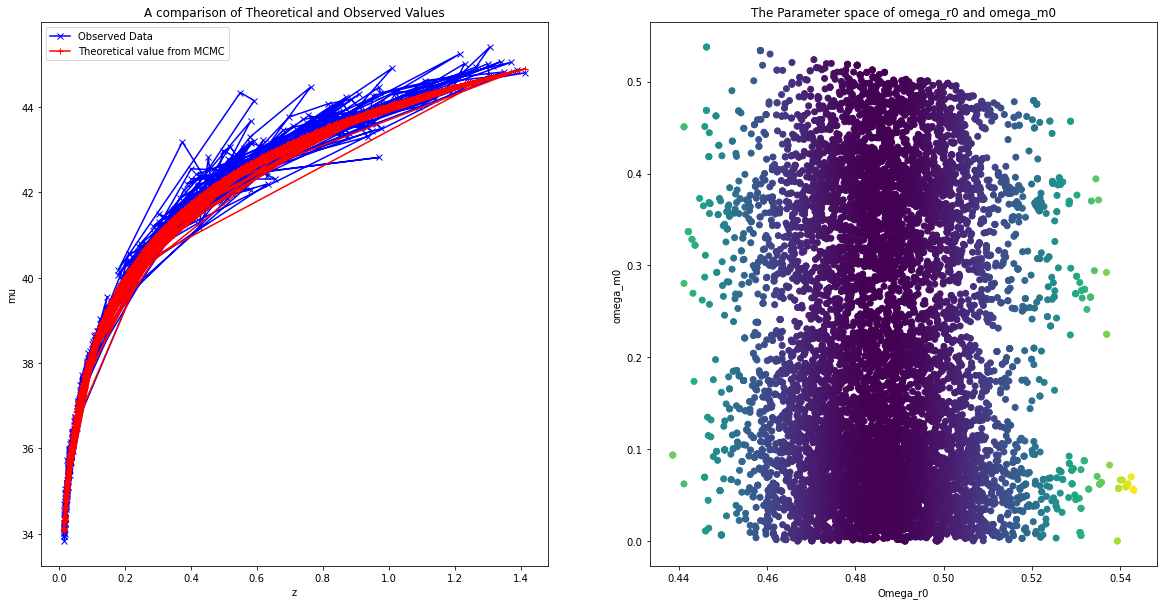

In [34]:
#For value calculation, we reject the initial values given by the algorithm so as to only select the values where the algorithm converges(as taught in class)
#Lets say we reject the initial 25% of the values
reject= sampl//25

print ('\n\n\nEstimated value of omega_r0 = '+ str(np.mean(mcmc_arr[reject:sampl,0])))
print ('Estimated value of omega_m0 = '+ str(np.mean(mcmc_arr[reject:sampl,1])))
print ('Estimated value of standard deviation of omega_r0 = '+ str(np.std(mcmc_arr[reject:sampl,0])))
print ('Estimated value of standard deviation of  omega_m0 = '+ str(np.std(mcmc_arr[reject:sampl,1])))
print ('Acceptance ratio is '+ str((accpt_nmbr*100)/sampl)+"  percent")

fig = plt.figure()
fig.set_size_inches(20,10)
#Plot the samples
ax1 = fig.add_subplot(121)
plt.xlabel("z")
plt.ylabel('mu')
plt.title("A comparison of Theoretical and Observed Values")
ax1.plot(z, mu, c='blue', marker='x',label="Observed Data")
ax2 = fig.add_subplot(122)
ax2.scatter(mcmc_arr[reject:,0], mcmc_arr[reject:,1],c = -mcmc_arr[reject:,2])
#plt.xlim(0.1,0.5)
#plt.ylim(0,1)
plt.xlabel("Omega_r0")
plt.ylabel('omega_m0')


#To plot the z vs mu function for out theoretical values
y_theoretical=np.empty(len(z))
for i in range(len(z)):
    y_theoretical[i]= mu_theory(z[i], np.mean(mcmc_arr[reject:,0]), np.mean(mcmc_arr[reject:,1]))
ax1.plot(z, y_theoretical, c='red', marker='+',label="Theoretical value from MCMC")
ax1.legend()
plt.title("The Parameter space of omega_r0 and omega_m0")
plt.show() 

In [46]:
#standard model with baryonic and dark energy
#number of samples 
sampl= 10000
#number of pars
par = 2


#assume the parameters have a gaussian distribution
sigma_omega= 0.01
sigma_n= 0.01
h0=69.8
#Defining part which comes inside integeration of distance Luminosity

inv_cov_mat= np.linalg.inv(cov_mat)
dmthSN= np.zeros(len(z))
dlthSN = np.zeros(len(z))
dldataSN=np.zeros(len(z))
error= np.zeros(len(z))
dlerror= np.zeros(len(z))

a=b=c=d=e=0
# DL theoretical from VCG model
def D_l(z,omega_m0):
    def int_func(x):
        return 1/(pow((1+x),2)*((1-omega_m0)/(1+x)**4+(omega_m0/(1+x)))**(0.5))
    g = quad(int_func,0,z)
    return (1+z)*g[0]*(300000/(h0))
#Function to calculate the value of mu_theory
def mu_theory(z,omega_m0):
        m=5*log(D_l(z,omega_m0),10)+25
        return m


# We now defile a likelihood function as given in the notes
# If the value comes out to be less than zero, set it to a very very small likelyhood
#Temporary variable to store mu(observation)- mu(theory)
dmu= np.empty(len(z))
def lnl(omega_m0):
    if(omega_m0<=0.0 or omega_m0>=1):
        loglikely=-1.e100
    else:
        for i in range(len(z)):
            dmu[i]= mu[i]- mu_theory(z[i],omega_m0)
        loglikely= -0.5*np.dot(dmu,np.dot(inv_cov_mat,dmu))
    return loglikely



#Empty array to store parameter values
# First Column = Omega_m
# Second Column = n

# A third parameter will be used to store the ln(likelihood) 

# Create a [1000,3] empty array
mcmc_arr= np.empty([sampl,par])

#Set initial likelyhood to a very low value so that next likelihood calculated is greater than 
#that and is accepted
#Filling up the first row of the three columns
mcmc_arr[0,0]= np.random.uniform()


#Calculate an initial likelyhood value and store it as the third column
mcmc_arr[0,1]=lnl(mcmc_arr[0,0])
accpt_nmbr=0

for i in range(1,sampl):
    lnl_prev= mcmc_arr[i-1,1]
    omega_m0_next= np.random.normal(mcmc_arr[i-1,0],sigma_omega)

       
    lnl_next= lnl(omega_m0_next)

    #Now comes the Metropolis Hastings algorithm to accept or reject the newly calculated point
    # Accept the point if likelyhood has increased
    if(lnl_next>lnl_prev):
        mcmc_arr[i,0]= omega_m0_next
        mcmc_arr[i,1]= lnl_next
        accpt_nmbr+=1
        #print("Accepted with a higher likelihood")
    else:
        x=np.random.uniform()
        #if not, we accept it with a lesser likelyhood defined by a threshold
        if(lnl_next-lnl_prev>np.log(x)): 
#This can be randomized everytime to select a different threshold, select a value x=np.random.uniform() 
#and take log(x)
            mcmc_arr[i,0]= omega_m0_next
            mcmc_arr[i,1]= lnl_next
            accpt_nmbr+=1
            #print("Accepted with a lesser likelihood")
        else:
            mcmc_arr[i,0]= mcmc_arr[i-1,0]
            mcmc_arr[i,1]= lnl_prev
            #print("This draw is rejected")




Estimated value of omega_m0 = 0.29540495392343624
Estimated value of standard deviation of  omega_m0 = 0.029665151601692887
Acceptance ratio is 89.43  percent


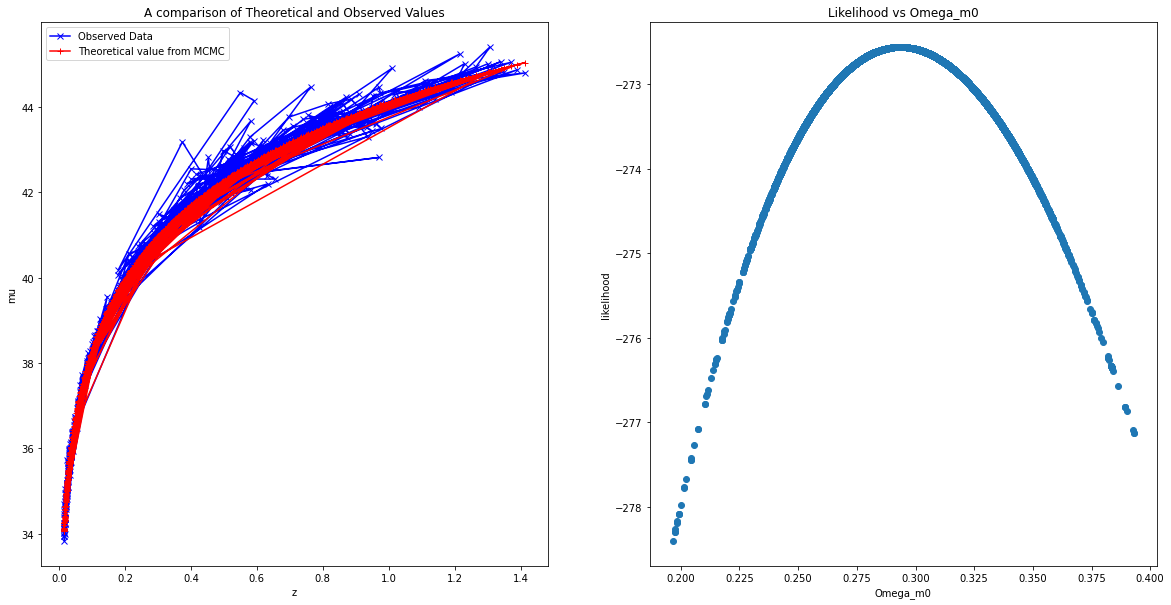

In [47]:
#For value calculation, we reject the initial values given by the algorithm so as to only select the values where the algorithm converges(as taught in class)
#Lets say we reject the initial 25% of the values
reject= sampl//25

print ('\n\n\nEstimated value of omega_m0 = '+ str(np.mean(mcmc_arr[reject:sampl,0])))
print ('Estimated value of standard deviation of  omega_m0 = '+ str(np.std(mcmc_arr[reject:sampl,0])))
print ('Acceptance ratio is '+ str((accpt_nmbr*100)/sampl)+"  percent")

fig = plt.figure()
fig.set_size_inches(20,10)
#Plot the samples
ax1 = fig.add_subplot(121)
plt.xlabel("z")
plt.ylabel('mu')
plt.title("A comparison of Theoretical and Observed Values")
ax1.plot(z, mu, c='blue', marker='x',label="Observed Data")
ax2 = fig.add_subplot(122)
ax2.scatter(mcmc_arr[reject:,0], mcmc_arr[reject:,1])
#plt.xlim(0.1,0.5)
#plt.ylim(0,1)
plt.xlabel("Omega_m0")
plt.ylabel('likelihood')


#To plot the z vs mu function for out theoretical values
y_theoretical=np.empty(len(z))
for i in range(len(z)):
    y_theoretical[i]= mu_theory(z[i], np.mean(mcmc_arr[reject:,0]))
ax1.plot(z, y_theoretical, c='red', marker='+',label="Theoretical value from MCMC")
ax1.legend()
plt.title("Likelihood vs Omega_m0")
plt.show() 